Written by Hadrien Padilla - July 30th 2025 

Purpose: 

Analysis of different nets to investigate the hippocampus' mechanism of representation of reward locations. The study focuses on a four fold evaluation: with and without reward representation crossed with and without reward directed behavior. 

Focus of Analysis: 

- Single-field analysis 
- Complex cell analysis 
- Population analysis 
- Shifting over time (over the course of training at different steps )

In [ ]:
# Import Nets
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from prnn.utils.predictiveNet import PredictiveNet
from prnn.utils.agent import RatInABoxAgent, RandomActionAgent
import itertools
import torch
import random
from prnn.utils.env import make_env
from prnn.utils.general import saveFig
from prnn.utils.figures import TrainingFigure
import matplotlib.pyplot as plt
from prnn.analysis.SpatialTuningAnalysis import SpatialTuningAnalysis
from prnn.analysis.OfflineTrajectoryAnalysis import OfflineTrajectoryAnalysis
from prnn.analysis.OfflineActivityAnalysis import SpontaneousActivityAnalysis
from prnn.analysis.representationalGeometryAnalysis import representationalGeometryAnalysis
from prnn.analysis.TuningCurveAnalysis import TuningCurveAnalysis

savefolder = 'Figures/RiaB/'

import os


os.chdir('/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN')

netname = 'multRNN_5win_i2_o2_no_reward-s1042-cpu'
netfolder = 'for_Hadrien/'
print(os.path.exists('nets/' + netfolder + netname + '.pkl'))
predictiveNet = PredictiveNet.loadNet(netfolder+netname)


# Use your ColorsReward shell (or whatever env you built)
env = predictiveNet.EnvLibrary[0]         


# Make sure the predictiveNet uses THIS env and the same n_obs
predictiveNet.env_shell = env

agent = RatInABoxAgent('Vis')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


AttributeError: Can't get attribute 'multRNN_5win_i2_o2' on <module 'prnn.utils.Architectures' from '/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/utils/Architectures.py'>

In [ ]:
#function to visualize bins when plotting
def overlay_angular_bins(center=(0.6, 0.6), radius=0.6, n_slices=6, **line_kwargs):
    """Overlay n_slices angular bins on the current Matplotlib axes."""
    ax = plt.gca()
    
    
    # Slice boundaries
    for k in range(n_slices):
        ang = k * (2*np.pi/n_slices)
        end = center + radius * np.array([np.cos(ang), np.sin(ang)])
        ax.plot([center[0], end[0]], [center[1], end[1]],
                **{"color": "k", "linewidth": 1, **line_kwargs})


In [ ]:
#run TCA, setting repeats because this is an old net that did not have repeats as a class-wide variable, won't need to do this with future nets
env.repeats = np.array([1], dtype=int)
TCA = TuningCurveAnalysis(predictiveNet)

Calculating EV_s
Running WAKE


/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/analysis/TuningCurveAnalysis.py:517: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(coords.T)
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/.newenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/.newenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


groups = {
            'untuned':untuned,
            'HD_cells':HD_cells,
            'single_field':single_field,
            'border_cells':border_cells,
            'spatial_HD':spatial_HD,
            'complex_cells':complex_cells
        }

In [ ]:
#get the indices of the single-field place cells (group 2 is single-field)
idx = np.flatnonzero(TCA.groupID == 2)
print(idx)


#get the centers of the the single-field place cells
g2 = np.flatnonzero(TCA.groupID == 2)
def com_center(tc):
    y, x = np.indices(tc.shape)
    w = np.clip(tc - np.nanmin(tc), 0, None)  # nonnegative weights
    s = w.sum()
    return (int(round((y*w).sum()/s)), int(round((x*w).sum()/s)))

centers_rc = np.array([com_center(TCA.tuning_curves[i]) for i in g2])
coords = predictiveNet.EnvLibrary[0].env.discrete_coords
start = TCA.start_pos                         # your code uses this offset
centers_xy = np.array([coords[r+start, c+start] for r,c in centers_rc])

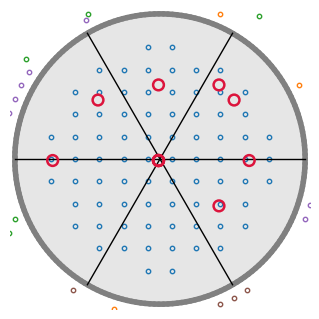

In [37]:
env.env.plot_environment()
overlay_angular_bins(center=(0.6, 0.6), radius=0.6, n_slices=6)
ax = plt.gca()
ax.scatter(
    centers_xy[:, 0], centers_xy[:, 1],
    s=60, facecolors='none', edgecolors='crimson', linewidths=1.8, zorder=10
)
plt.show()

In [38]:
#function to count the number of place cells in each bin 
def count_angular_bins(points_xy,
                       center=(0.6, 0.6),
                       n_slices=6,
                       start_angle=0.0,
                       radius=None):
    pts = np.asarray(points_xy, float)
    c = np.asarray(center, float)
    v = pts - c
    r = np.hypot(v[:,0], v[:,1])
    theta = (np.arctan2(v[:,1], v[:,0]) - start_angle) % (2*np.pi)
    w = 2*np.pi / n_slices
    idx = np.floor(theta / w).astype(int)          # 0..n_slices-1
    counts = np.bincount(idx[idx >= 0], minlength=n_slices)
    return counts, idx

In [ ]:
from scipy.stats import chi2  # for p-value
#method to compute chi-squared test to see if there is significance with the fraction of single-field place cell distribution
#NOTE: you need an expected count of 5 per bin for chi square to be reliable 
def compute_chi_squared(counts):
    expected = np.mean(counts)  # uniform distribution
    chi2_stat = np.sum((counts - expected)**2 / expected)

    df = counts.size - 1
    pval = 1.0 - chi2.cdf(chi2_stat, df)

    return chi2_stat, pval, df, expected

counts per bin: [2 1 1 6 0 2]


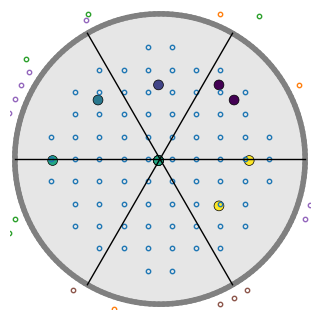

(11.0, 0.05137998348306949, 5, 2.0)


In [ ]:
#plotting env, overlaying bins, and place field centers color-coded by the bin they belong in

counts, bin_idx = count_angular_bins(centers_xy, center=(0.6,0.6),
                                     n_slices=6, start_angle=0.0, radius=0.6)
print("counts per bin:", counts)
env.env.plot_environment()
overlay_angular_bins(center=(0.6, 0.6), radius=0.6, n_slices=6)
ax = plt.gca()
ax.scatter(centers_xy[:,0], centers_xy[:,1], c=np.clip(bin_idx,0,None),
           s=50, edgecolors='k', linewidths=0.5)
plt.show()
print(compute_chi_squared(counts))

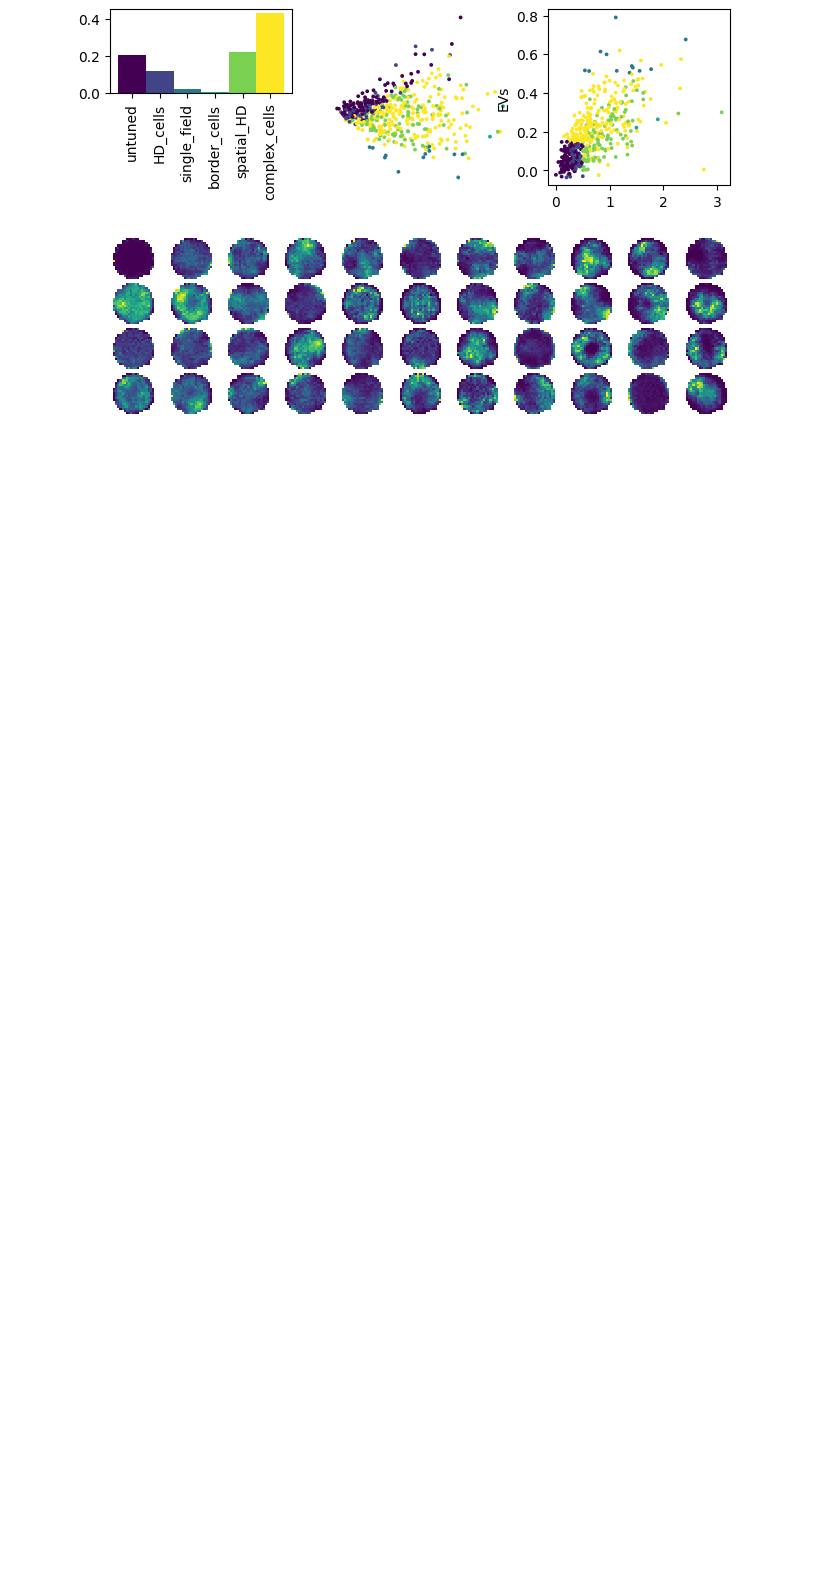

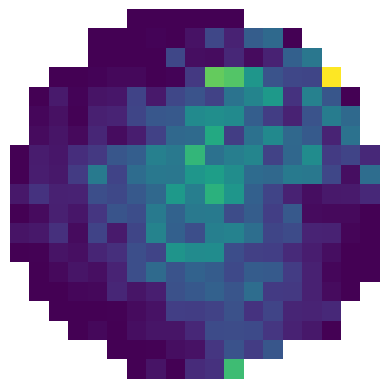

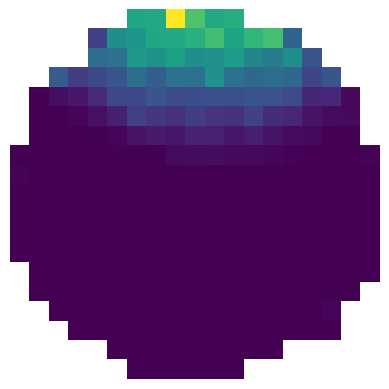

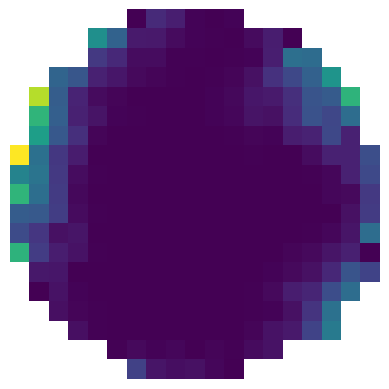

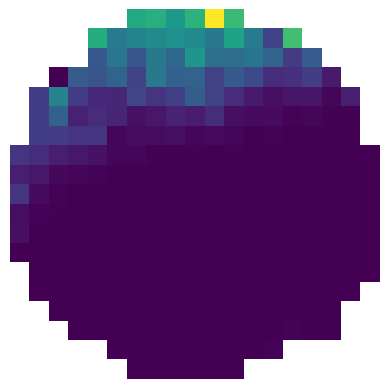

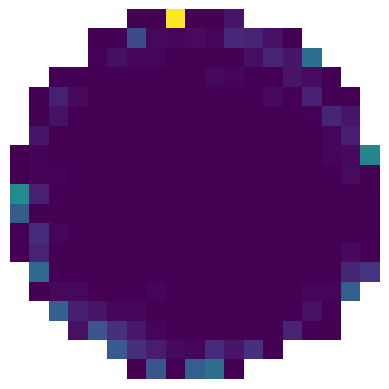

<Figure size 640x480 with 0 Axes>

In [46]:
TCA.cellClassificationFigure()